# Using STAC client to query repositories

https://colab.research.google.com/github/hanouma/GeoPipelines/blob/main/Sentinel1Processing.ipynb

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hanouma/GeoPipelines/blob/main/tryingSTAC.ipynb)

In [1]:
#!pip install planetary_computer

In [2]:
#!pip install dask[distributed]

In [3]:
#!pip install odc.stac

In [4]:
#!pip install -U pip

In [5]:
#!pip install xarray

In [6]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client

from odc.stac import configure_rio, stac_load

In [7]:
cfg = {
    "sentinel-2-l2a": {
        "assets": {
            "*": {"data_type": "uint16", "nodata": 0},
            "SCL": {"data_type": "uint8", "nodata": 0},
            "visual": {"data_type": "uint8", "nodata": 0},
        },
    },
    "*": {"warnings": "ignore"},
}

{'sentinel-2-l2a': {'assets': {'*': {'data_type': 'uint16', 'nodata': 0},
   'SCL': {'data_type': 'uint8', 'nodata': 0},
   'visual': {'data_type': 'uint8', 'nodata': 0}}},
 '*': {'warnings': 'ignore'}}

# Initializing STAC client
## adding this section



In [9]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.51 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43531,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.51 GiB
Comm: tcp://127.0.0.1:43557,Total threads: 3
Dashboard: http://127.0.0.1:45289/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:39989,


In [10]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# query = catalog.search(
#     collections=["sentinel-2-l2a"],
#     datetime="2022-05",
#     query={"s2:mgrs_tile": dict(eq="06VVN")},#  06VVN 36RUV

# )

# items = list(query.get_items())
# print(f"Found: {len(items):d} datasets")

In [11]:
query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2022-05",
    query={"s2:mgrs_tile": dict(eq="36RUV")},#  06VVN 36RUV

)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 14 datasets


In [12]:
resolution = 10
SHRINK = 4
if client.cluster.workers[0].memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

xx = stac_load(
    items,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
    resolution=resolution,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

/home/hhammad/miniconda3/envs/stenv/lib/python3.10/site-packages/distributed/worker_memory.py:507: FutureWarning: The `Nanny.memory_limit` attribute has been moved to `Nanny.memory_manager.memory_limit
  warnings.warn(


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset>
Dimensions:      (y: 2745, x: 2745, time: 13)
Coordinates:
  * y            (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.39e+06 3.39e+06
  * x            (x) float64 3e+05 3.001e+05 3.001e+05 ... 4.097e+05 4.098e+05
    spatial_ref  int32 32636
  * time         (time) datetime64[ns] 2022-05-01T08:36:11.024000 ... 2022-05...
Data variables: (12/16)
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

By default stac_load will return all the data bands using canonical asset names. But we can also request a subset of bands, by supplying bands= parameter. When going this route you can also use “common name” to refer to a band.

In this case we request red,green,blue,nir bands which are common names for bands B04,B03,B02,B08 and SCL band which is a canonical name.

In [13]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir", "SCL"],
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    stac_cfg=cfg,
    patch_url=pc.sign,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir,SCL


<xarray.Dataset>
Dimensions:      (y: 2745, x: 2745, time: 13)
Coordinates:
  * y            (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.39e+06 3.39e+06
  * x            (x) float64 3e+05 3.001e+05 3.001e+05 ... 4.097e+05 4.098e+05
    spatial_ref  int32 32636
  * time         (time) datetime64[ns] 2022-05-01T08:36:11.024000 ... 2022-05...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [9]:
def to_float(xx):
    _xx = xx.astype("float32")
    nodata = _xx.attrs.pop("nodata", None)
    if nodata is None:
        return _xx
    return _xx.where(xx != nodata)


def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

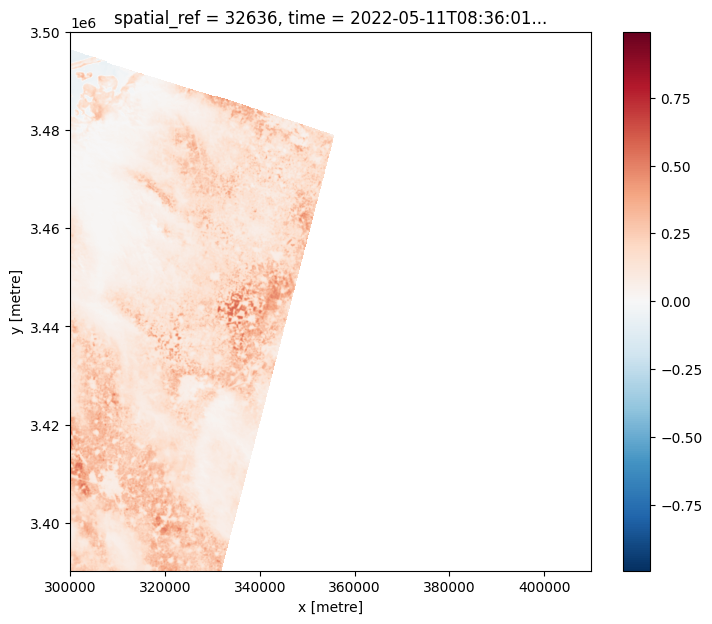

In [10]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir = to_float(xx.nir)
red = to_float(xx.red)
ndvi = (nir - red) / (
    nir + red
)  # < This is still a lazy Dask computation (no data loaded yet)

# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

/home/hhammad/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/hhammad/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


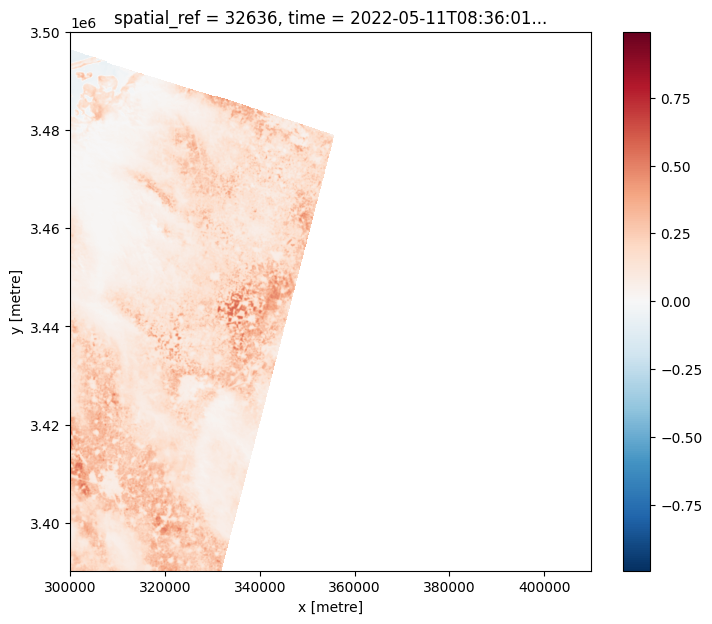

In [11]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir = to_float(xx.nir)
red = to_float(xx.red)
ndvi = (nir - red) / (
    nir + red
)  # < This is still a lazy Dask computation (no data loaded yet)

# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

In [12]:
xx = xx.isel(time=np.s_[:6])

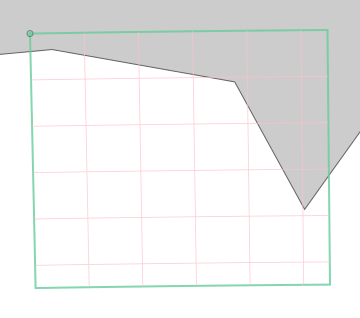

In [13]:
# fmt: off
scl_colormap = np.array(
    [
        [255,   0, 255, 255],  # 0  - NODATA
        [255,   0,   4, 255],  # 1  - Saturated or Defective
        [0  ,   0,   0, 255],  # 2  - Dark Areas
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow
        [3  , 139,  80, 255],  # 4  - Vegetation
        [192, 132,  12, 255],  # 5  - Bare Ground
        [0 , 0, 0, 255],    # 6  - Water
        [117,   0,  27, 255],  # 7  - Unclassified
        [208, 208, 208, 255],  # 8  - Cloud
        [244, 244, 244, 255],  # 9  - Definitely Cloud
        [195, 231, 240, 255],  # 10 - Thin Cloud
        [222, 157, 204, 255],  # 11 - Snow or Ice
    ],
    dtype="uint8",
)
# fmt: on

# Load SCL band, then convert to RGB using color scheme above
scl_rgba = colorize(xx.SCL.compute(), scl_colormap)

# Check we still have geo-registration
scl_rgba.odc.geobox

# fmt: off
scl_colormap = np.array(
    [
        [255,   0, 255, 255],  # 0  - NODATA
        [255,   0,   4, 255],  # 1  - Saturated or Defective
        [0  ,   0,   0, 255],  # 2  - Dark Areas
        [97 ,  97,  97, 255],  # 3  - Cloud Shadow
        [3  , 139,  80, 255],  # 4  - Vegetation
        [192, 132,  12, 255],  # 5  - Bare Ground
        [21 , 103, 141, 255],  # 6  - Water
        [117,   0,  27, 255],  # 7  - Unclassified
        [208, 208, 208, 255],  # 8  - Cloud
        [244, 244, 244, 255],  # 9  - Definitely Cloud
        [195, 231, 240, 255],  # 10 - Thin Cloud
        [222, 157, 204, 255],  # 11 - Snow or Ice
    ],
    dtype="uint8",
)
# fmt: on

# Load SCL band, then convert to RGB using color scheme above
scl_rgba = colorize(xx.SCL.compute(), scl_colormap)

# Check we still have geo-registration
scl_rgba.odc.geobox

_ = scl_rgba.plot.imshow(col="time", col_wrap=3, size=3, interpolation="antialiased")

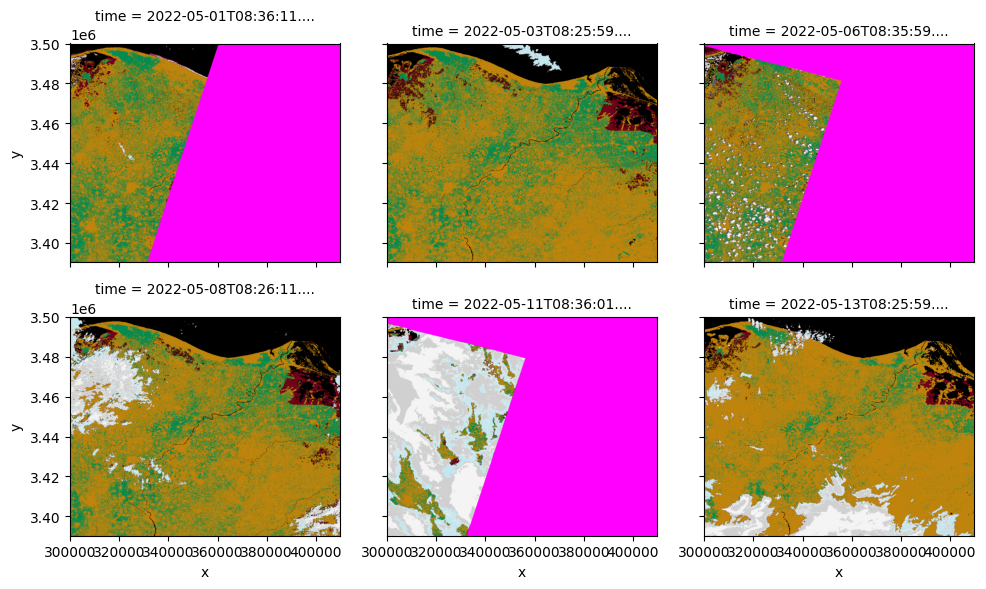

In [14]:
_ = scl_rgba.plot.imshow(col="time", col_wrap=3, size=3, interpolation="antialiased")

In [15]:
to_save = scl_rgba.isel(time=3)
fname = f"SCL2-{to_save.time.dt.strftime('%Y%m%d').item()}.tif"
print(f"Saving to: '{fname}'")

Saving to: 'SCL2-20220508.tif'


In [16]:
scl_rgba.isel(time=3).odc.write_cog(
    fname,
    overwrite=True,
    compress="webp",
    webp_quality=90,
)

PosixPath('SCL2-20220508.tif')

In [ ]:
scl_rgba.isel(time=3).odc.write_cog(
    fname,
    overwrite=True,
    compress="lzw",
    webp_quality=90,
)

In [30]:
!pip install georaster

  Preparing metadata (setup.py) ... done
  Created wheel for georaster: filename=georaster-1.25-py3-none-any.whl size=15092 sha256=e6bbbd4381255eaf7d53ca7ca79db61d692ccd7b3924a6347107e10ea36e049d
  Stored in directory: /home/hhammad/.cache/pip/wheels/9a/94/a9/37f9c58501ccb324c89a3e16b6edeee237fb6f669d54c27e0c
Successfully built georaster


In [42]:
import rasterio
import rasterio.plot

In [41]:
import rasterio.plot 

In [34]:
dataset = rs.open('SCL2-20220508.tif')

In [38]:
dataset.count,  dataset.height, dataset.width , dataset.crs

(4, 2745, 2745, CRS.from_epsg(32636))

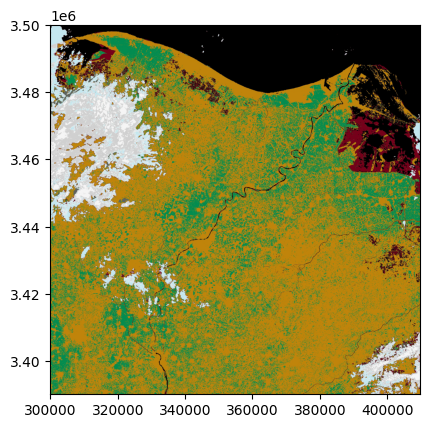

<Axes: >

In [43]:
fp = r'SCL2-20220508.tif'
img = rasterio.open(fp)
rasterio.plot.show(img)

# Other experiments

###  https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-deafrica.html

### s2_l2a
https://explorer.digitalearth.africa/products/s2_l2a#definition-doc


In [44]:
config = {
    "s2_l2a": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "SCL": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
        "aliases": {
            "costal_aerosol": "B01",
            "blue": "B02",
            "green": "B03",
            "red": "B04",
            "red_edge_1": "B05",
            "red_edge_2": "B06",
            "red_edge_3": "B07",
            "nir": "B08",
            "nir_narrow": "B08A",
            "water_vapour": "B09",
            "swir_1": "B11",
            "swir_2": "B12",
            "mask": "SCL",
            "aerosol_optical_thickness": "AOT",
            "scene_average_water_vapour": "WVP",
        },
    }
}

In [45]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [46]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [47]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [30.76, 30.49, 31.77, 31.50]
# bbox = [37.76, 12.49, 37.77, 12.50]
# Set a start and end date
start_date = "2020-09-01"
end_date = "2020-12-01"

# Set the STAC collections
collections = ["s2_l2a"]

In [48]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 145 datasets


In [49]:
crs = "EPSG:4326"
# crs = "EPSG:6933"

resolution = 20

ds = stac_load(
    items,
    bands=("red", "green", "blue", "nir"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset>
Dimensions:      (latitude: 1, longitude: 1, time: 36)
Coordinates:
  * latitude     (latitude) float64 30.0
  * longitude    (longitude) float64 30.0
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2020-09-03T08:51:36 ... 2020-11-29T08:...
Data variables:
    red          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    nir          (time, latitude, longitude) uint16 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>

In [50]:
ds["NDVI"] = (ds.nir - ds.red) / (ds.nir + ds.red)


ds.NDVI.compute().plot(col="time", col_wrap=6, vmin=0, vmax=1)

/home/hhammad/.local/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/home/hhammad/miniconda3/envs/stenv/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hhammad/miniconda3/envs/stenv/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hhammad/miniconda3/envs/stenv/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hhammad/miniconda3/envs/stenv/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/hhammad/miniconda3/envs/stenv/lib/pyt

TypeError: No numeric data to plot.